In [1]:
! pip install tensorflow

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 

In [3]:
df = pd.read_csv('train.csv')
df.shape

(33126, 8)

Total training dataset is 33126

In [4]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [5]:
df['image_name'].nunique()

33126

Image name is the unique identifier

In [6]:
df.groupby('benign_malignant').count()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,target
benign_malignant,,,,,,,
benign,32542,32542,32477,32474,32024,32542,32542
malignant,584,584,584,584,575,584,584


In [7]:
df.groupby('target').count()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant
target,,,,,,,
0,32542,32542,32477,32474,32024,32542,32542
1,584,584,584,584,575,584,584


'Target' is the label column: 0 - benign; 1 - malignant

'Target' and 'benign_malignant' are essentially saying the same. Hence removing the latter.

In [8]:
del df['benign_malignant']

diagnosis
atypical melanocytic proliferation        1
cafe-au-lait macule                       1
lentigo NOS                              44
lichenoid keratosis                      37
melanoma                                584
nevus                                  5193
seborrheic keratosis                    135
solar lentigo                             7
unknown                               27124
Name: image_name, dtype: int64


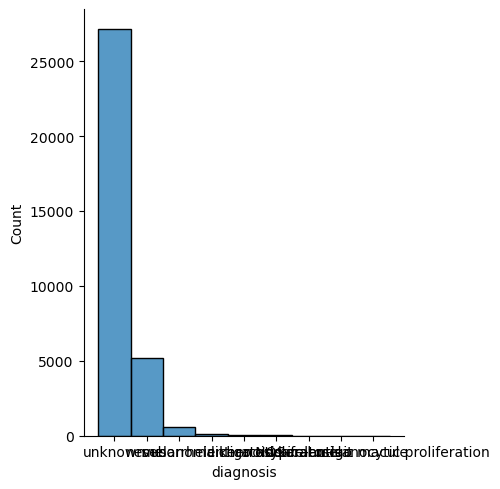

In [9]:
print(df.groupby('diagnosis')['image_name'].count())
from matplotlib import pyplot
# plt.figure(figsize=(15,8))
sns.displot(data = df, x="diagnosis")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 1.8+ MB


In [11]:
df.isna().sum()

image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
target                             0
dtype: int64

There are some null values in 'sex', age_approx' and 'anatom_site_general_challenge' fields. But they do not matter for now as we are only going to use the images and their labels.

In [12]:
df.groupby('patient_id')['target'].count()

patient_id
IP_0001230     6
IP_0019713    13
IP_0036322     5
IP_0038436     3
IP_0038545    28
              ..
IP_9989332    10
IP_9992027    39
IP_9995095    14
IP_9996429     3
IP_9997715    11
Name: target, Length: 2056, dtype: int64

In [13]:
x = df.groupby('patient_id')['target'].agg([np.min, np.max])
gp=pd.DataFrame(x).reset_index()
gp[(gp['amin'] == 0) & (gp['amax'] == 1)]

,patient_id,amin,amax
4,IP_0038545,0,1
10,IP_0059113,0,1
23,IP_0093378,0,1
31,IP_0135517,0,1
38,IP_0170821,0,1
...,...,...,...
2042,IP_9936643,0,1
2043,IP_9942136,0,1
2044,IP_9952683,0,1
2045,IP_9954107,0,1


For 427 patients, we have images of both target label: malignant and benign.

In [15]:
df[df['diagnosis'] == 'unknown']['target'].value_counts()

0    27124
Name: target, dtype: int64

It seems, where the diagnosis is unknown, the target is only 0. Hence we can remove them from our training data.

In [16]:
df = df[df['diagnosis'] != 'unknown']

In [17]:
df['diagnosis'].value_counts()

nevus                                 5193
melanoma                               584
seborrheic keratosis                   135
lentigo NOS                             44
lichenoid keratosis                     37
solar lentigo                            7
cafe-au-lait macule                      1
atypical melanocytic proliferation       1
Name: diagnosis, dtype: int64

In [18]:
df[(df['diagnosis'] == 'atypical melanocytic proliferation') | (df['diagnosis'] == 'cafe-au-lait macule') | (df['diagnosis'] == 'solar lentigo')]['target']

4176     0
9792     0
9987     0
13765    0
23051    0
24242    0
24485    0
27630    0
30473    0
Name: target, dtype: int64

atypical melanocytic proliferation, cafe-au-lait macule and solar lentigo are few in numbers and all have target as 0. Hence we are removing them.

In [19]:
df = df[~df['diagnosis'].isin(['atypical melanocytic proliferation','cafe-au-lait macule','solar lentigo'])]

In [20]:
df['target'].value_counts()/ df.shape[0] * 100

0    90.255298
1     9.744702
Name: target, dtype: float64

We could still see a huge target class imbalance in data

In [27]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,target
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,0
12,ISIC_0076995,IP_2235340,female,55.0,torso,nevus,0
26,ISIC_0084086,IP_4023055,male,60.0,lower extremity,nevus,0
27,ISIC_0084270,IP_2961528,male,40.0,lower extremity,nevus,0
28,ISIC_0084395,IP_0175539,female,45.0,torso,nevus,0


In [22]:
df['anatom_site_general_challenge'].value_counts()

torso              3341
lower extremity    1607
upper extremity     716
head/neck           259
palms/soles           7
oral/genital          5
Name: anatom_site_general_challenge, dtype: int64

anatom_site_general_challenge  target
head/neck                      0          185
                               1           74
lower extremity                0         1483
                               1          124
oral/genital                   0            1
                               1            4
palms/soles                    0            2
                               1            5
torso                          0         3084
                               1          257
upper extremity                0          605
                               1          111
Name: image_name, dtype: int64


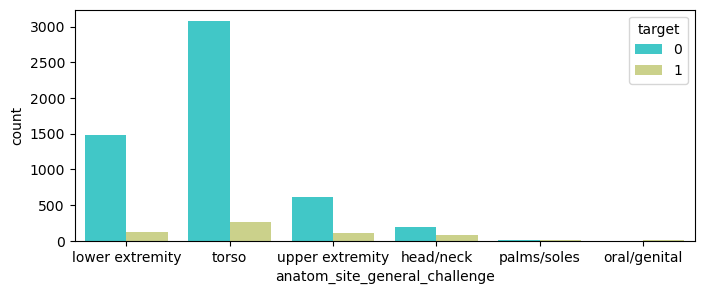

In [48]:
print(df.groupby(['anatom_site_general_challenge','target'])['image_name'].count())
plt.figure(figsize=(8,3))
sns.countplot(x='anatom_site_general_challenge',data=df, palette='rainbow', hue = 'target')
plt.show()

sex     target
female  0         2407
        1          220
male    0         3002
        1          364
Name: image_name, dtype: int64


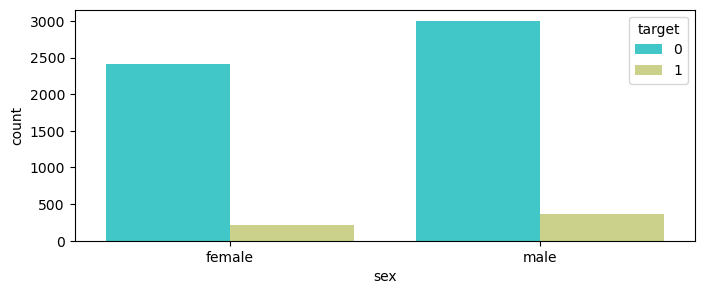

In [49]:
print(df.groupby(['sex','target'])['image_name'].count())
plt.figure(figsize=(8,3))
sns.countplot(x='sex',data=df, palette='rainbow', hue = 'target')
plt.show()

age_approx  target
15.0        0           1
            1           2
20.0        0          15
            1           6
25.0        0          99
            1          16
30.0        0         287
            1          24
35.0        0         457
            1          25
40.0        0         627
            1          24
45.0        0         824
            1          54
50.0        0         926
            1          53
55.0        0         796
            1          64
60.0        0         475
            1          65
65.0        0         324
            1          70
70.0        0         262
            1          58
75.0        0         200
            1          62
80.0        0          75
            1          36
85.0        0          34
            1           9
90.0        0           4
            1          16
Name: image_name, dtype: int64


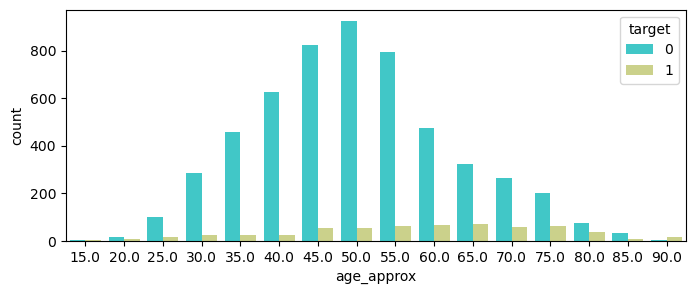

In [50]:
print(df.groupby(['age_approx','target'])['image_name'].count())
plt.figure(figsize=(8,3))
sns.countplot(x='age_approx',data=df, palette='rainbow', hue = 'target')
plt.show()

diagnosis             target
lentigo NOS           0           44
lichenoid keratosis   0           37
melanoma              1          584
nevus                 0         5193
seborrheic keratosis  0          135
Name: image_name, dtype: int64


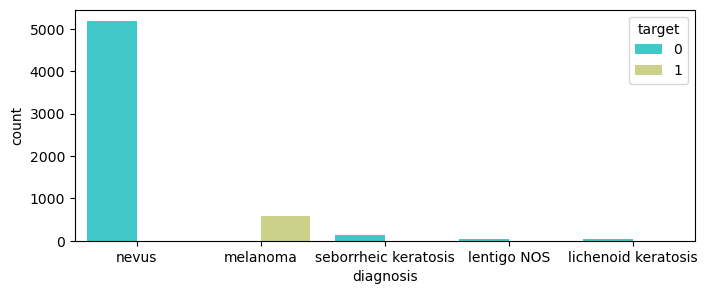

In [52]:
print(df.groupby(['diagnosis','target'])['image_name'].count())
plt.figure(figsize=(8,3))
sns.countplot(x='diagnosis',data=df, palette='rainbow', hue = 'target')
plt.show()


#### Image Preprocessing

In [74]:
labels = []
data = []
img_dir = r'C:/Users/aje29/Downloads/jpeg/train/'
for i in range(df.shape[0]):
    data.append(img_dir + df['image_name'].iloc[i] + '.jpg')
    labels.append(df['target'].iloc[i])
data = pd.DataFrame(data)
data.columns = ['images']
data['target'] = labels

In [75]:
pd.set_option("max_colwidth", 55)
data.head()

,images,target
0,C:/Users/aje29/Downloads/jpeg/train/ISIC_0052212.jpg,0
1,C:/Users/aje29/Downloads/jpeg/train/ISIC_0076995.jpg,0
2,C:/Users/aje29/Downloads/jpeg/train/ISIC_0084086.jpg,0
3,C:/Users/aje29/Downloads/jpeg/train/ISIC_0084270.jpg,0
4,C:/Users/aje29/Downloads/jpeg/train/ISIC_0084395.jpg,0


In [76]:
df_test = pd.read_csv('test.csv')
test_data = []
img_dir = r'C:/Users/aje29/Downloads/jpeg/test/'
for i in range(df_test.shape[0]):
    test_data.append(img_dir + df_test['image_name'].iloc[i] + '.jpg')
test_data = pd.DataFrame(test_data)
test_data.columns = ['images']

In [77]:
test_data.head()

,images
0,C:/Users/aje29/Downloads/jpeg/test/ISIC_0052060.jpg
1,C:/Users/aje29/Downloads/jpeg/test/ISIC_0052349.jpg
2,C:/Users/aje29/Downloads/jpeg/test/ISIC_0058510.jpg
3,C:/Users/aje29/Downloads/jpeg/test/ISIC_0073313.jpg
4,C:/Users/aje29/Downloads/jpeg/test/ISIC_0073502.jpg


In [78]:
# train - validation split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data['images'],data['target'], test_size=0.2, random_state=1234)

In [79]:
train=pd.DataFrame(X_train)
train.columns=['images']
train['target']=y_train

validation=pd.DataFrame(X_val)
validation.columns=['images']
validation['target']=y_val

In [80]:
print(train.shape, validation.shape)

(4794, 2) (1199, 2)


In [82]:
#image data augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True)

val_datagen=ImageDataGenerator(rescale=1./255)

In [85]:
train_generator = train_datagen.flow_from_dataframe(
    train,
    x_col='images',
    y_col='target',
    target_size=(224, 224),
    batch_size=256,
    shuffle=True,
    class_mode='raw') #raw since target is numerical, should use 'categorical' if target is str

validation_generator = val_datagen.flow_from_dataframe(
    validation,
    x_col='images',
    y_col='target',
    target_size=(224, 224),
    shuffle=False, # shuffle should be false for validation, true for train
    batch_size=256,
    class_mode='raw')

Found 4794 validated image filenames.
Found 1199 validated image filenames.


In [91]:
# Building a CNN model

from tensorflow.keras import models, layers

model = models.Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(1, activation='softmax')) # dense unit = 1 -> should check; it is the dimension of output
                                                # activation should be sigmoid for binary_crossentropy
                                                # activation should be tanh and target should be -1,1 for hinge
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 26, 26, 64)      

In [92]:
# train the model

model.compile(optimizer='adam',
              loss='categorical_crossentropy', # should try different loss function - binary_crossentropy, hinge
              metrics=['accuracy'])

fit = model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
19/19 [==============================] - 342s 18s/step - loss: 0.0000e+00 - accuracy: 0.1003 - val_loss: 0.0000e+00 - val_accuracy: 0.0859
Epoch 2/5
19/19 [==============================] - 326s 17s/step - loss: 0.0000e+00 - accuracy: 0.1003 - val_loss: 0.0000e+00 - val_accuracy: 0.0859
Epoch 3/5
19/19 [==============================] - 320s 17s/step - loss: 0.0000e+00 - accuracy: 0.1003 - val_loss: 0.0000e+00 - val_accuracy: 0.0859
Epoch 4/5
19/19 [==============================] - 322s 17s/step - loss: 0.0000e+00 - accuracy: 0.1003 - val_loss: 0.0000e+00 - val_accuracy: 0.0859
Epoch 5/5
19/19 [==============================] - 324s 17s/step - loss: 0.0000e+00 - accuracy: 0.1003 - val_loss: 0.0000e+00 - val_accuracy: 0.0859


In [93]:
# model 2 -> binary_crossentropy

model = models.Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(1, activation='sigmoid')) # dense unit = 1 -> should check; it is the dimension of output
                                                # activation should be sigmoid for binary_crossentropy
                                                # activation should be tanh and target should be -1,1 for hinge
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 26, 26, 64)      

In [94]:
# train the model

model.compile(optimizer='adam',
              loss='binary_crossentropy', # should try different loss function - binary_crossentropy, hinge
              metrics=['accuracy'])

fit = model.fit(train_generator, epochs=2, validation_data=validation_generator)

Epoch 1/2
19/19 [==============================] - 329s 17s/step - loss: 0.3496 - accuracy: 0.8997 - val_loss: 0.2551 - val_accuracy: 0.9141
Epoch 2/2
19/19 [==============================] - 319s 17s/step - loss: 0.2705 - accuracy: 0.8965 - val_loss: 0.2283 - val_accuracy: 0.9216


In [97]:
# data_hinge = data.copy()
data_hinge['target'].replace(0, -1, inplace = True)

In [104]:
data_hinge['target'].value_counts()

-1    5409
 1     584
Name: target, dtype: int64

In [99]:
X_trainh, X_valh, y_trainh, y_valh = train_test_split(data_hinge['images'],data_hinge['target'], test_size=0.2, random_state=1234)

In [100]:
trainh=pd.DataFrame(X_trainh)
trainh.columns=['images']
trainh['target']=y_trainh

validationh=pd.DataFrame(X_valh)
validationh.columns=['images']
validationh['target']=y_valh

In [105]:
print(trainh.shape, validationh.shape)

(4794, 2) (1199, 2)


In [101]:
train_generatorh = train_datagen.flow_from_dataframe(
    trainh,
    x_col='images',
    y_col='target',
    target_size=(224, 224),
    batch_size=256,
    shuffle=True,
    class_mode='raw') #raw since target is numerical, should use 'categorical' if target is str

validation_generatorh = val_datagen.flow_from_dataframe(
    validationh,
    x_col='images',
    y_col='target',
    target_size=(224, 224),
    shuffle=False, # shuffle should be false for validation, true for train
    batch_size=256,
    class_mode='raw')

Found 4794 validated image filenames.
Found 1199 validated image filenames.


In [102]:
# model 3 : loss func: hinge, activation: tanh, target: -1,1

model = models.Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(1, activation='tanh')) # dense unit = 1 -> should check; it is the dimension of output
                                                # activation should be sigmoid for binary_crossentropy
                                                # activation should be tanh and target should be -1,1 for hinge
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 26, 26, 64)      

In [103]:
# train the model

model.compile(optimizer='adam',
              loss='hinge', # should try different loss function - binary_crossentropy, hinge
              metrics=['accuracy'])

fit = model.fit(train_generatorh, epochs=2, validation_data=validation_generatorh)

# accuracy 0, hence interrupted

Epoch 1/2
 9/19 [=============>................] - ETA: 2:27 - loss: 0.2895 - accuracy: 0.0000e+00

KeyboardInterrupt: 

Now try changing learning rate for Optimizer (Adam) while using binary_crossentropy loss function

In [106]:
# model 2 -> binary_crossentropy

model = models.Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(1, activation='sigmoid')) # dense unit = 1 -> should check; it is the dimension of output
                                                # activation should be sigmoid for binary_crossentropy
                                                # activation should be tanh and target should be -1,1 for hinge
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 26, 26, 64)      

In [109]:
# train the model
optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', # should try different loss function - binary_crossentropy, hinge
              metrics=['accuracy'])

fit = model.fit(train_generator, epochs=2, validation_data=validation_generator)

C:\Users\aje29\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/2
19/19 [==============================] - 385s 20s/step - loss: 1.3795 - accuracy: 0.8133 - val_loss: 0.2913 - val_accuracy: 0.9141
Epoch 2/2
19/19 [==============================] - 356s 19s/step - loss: 0.3009 - accuracy: 0.8992 - val_loss: 0.2472 - val_accuracy: 0.9141
